In [ ]:
#| default_exp activations

### Activations 

Notebook to cover the activations aspects of the miniai library.  This includes setting up and using hooks to capture activations, as well as functions to collate activations stats.

Routines to plot activations are also included

In general tests need to be added to this notebook

In [ ]:
#|export
from __future__ import annotations
import random,math,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from fastcore.test import test_close
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from typing import Callable
import logging

from torch import tensor,nn,optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from datasets import load_dataset

from miniai.datasets import *
from miniai.utils import set_seed, to_cpu
from miniai.plotting import get_grid, show_image
from miniai.callbacks import *

In [ ]:
from miniai.learner import *

In [ ]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
mpl.rcParams['figure.constrained_layout.use'] = True
logging.disable(logging.WARNING)

In [ ]:
x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)
bs = 1024

@inplace
def transformi(b): b[x] = [TF.to_tensor(o) for o in b[x]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train

In [ ]:
def conv(ni, nf, ks=3, act=True):

    res = nn.Conv2d(ni, nf, ks, stride=2, padding=ks//2)
    if act==True:
        res = nn.Sequential(res, nn.ReLU())
    return res

# Create a basic CNN classifier
def cnn_layers():
    return [
        conv(1, 8, ks=5), # 14*14
        conv(8, 16), #7*7
        conv(16, 32), #4*4
        conv(32, 64), #2*2
        conv(64, 10, act=False), #1*1
        nn.Flatten()
    ]

In [ ]:
from torcheval.metrics import MulticlassAccuracy

In [ ]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]

In [ ]:
def fit(model, epochs, xtra_cbs=None):
    learn = Learner(model, dls=dls, loss_func=F.cross_entropy,  lr=0.6, cbs=cbs+fc.L(xtra_cbs))
    learn.fit(epochs)
    return learn

accuracy,loss,epoch,train
0.154,2.301,0,train
0.197,2.117,0,eval


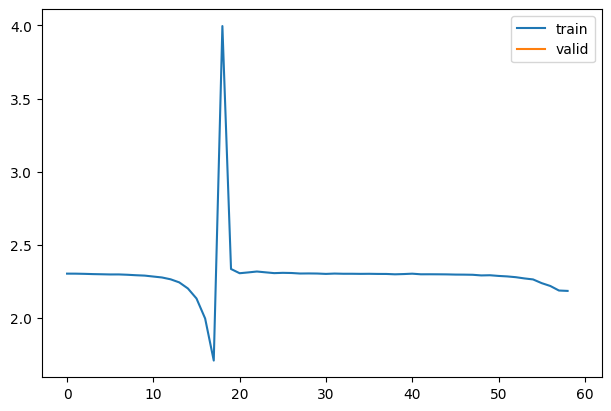

In [ ]:
set_seed(1)
learn = fit(nn.Sequential(*cnn_layers()), epochs=1)

### Hooks

Hooks are necessary to extract internal values from the NN, which can be useful to understand how a network is behaving, as well as using internal values for control etc.

To develop understanding of hooks a class will be generated that allows us to store and then recall / process mean and standard deviation of layers in a model as it trains

In [ ]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        # Create an empty list for each layer to save means
        self.act_means = [[] for _ in layers]
        self.act_stds = [[] for _ in layers]
        
    def __call__(self, x):
        """ pass the input through each layer, saving the activation stats at each stage
        """
        for i, l in enumerate(self.layers):
            x = l(x)
            self.act_means[i].append(to_cpu(x).mean())
            self.act_stds[i].append(to_cpu(x).std())
        return x
    
    #def __iter__(self): 
    #    print(f'calling iter')
    #    return iter(self.layers)

accuracy,loss,epoch,train
0.151,2.299,0,train
0.300,2.138,0,eval


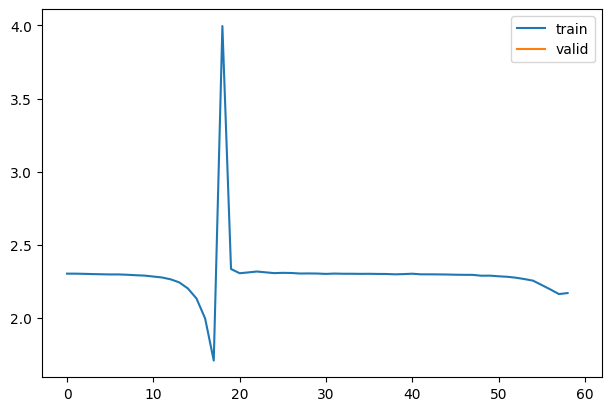

In [ ]:
set_seed(1)
model = SequentialModel(*cnn_layers())
learn = fit(model, epochs=1)

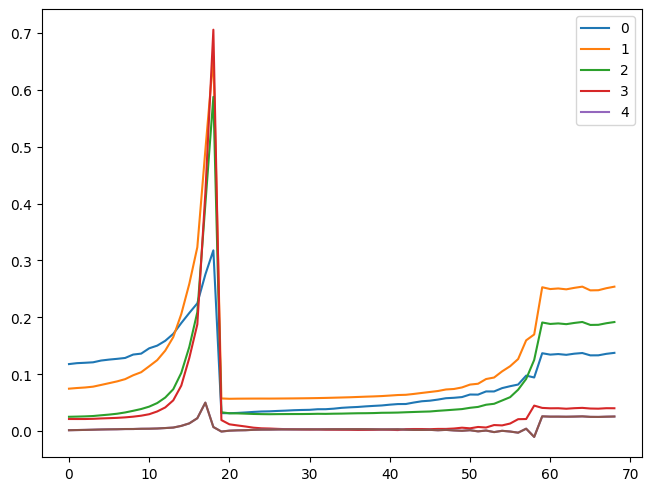

In [ ]:
for l in model.act_means: plt.plot(l)
plt.legend(range(5));

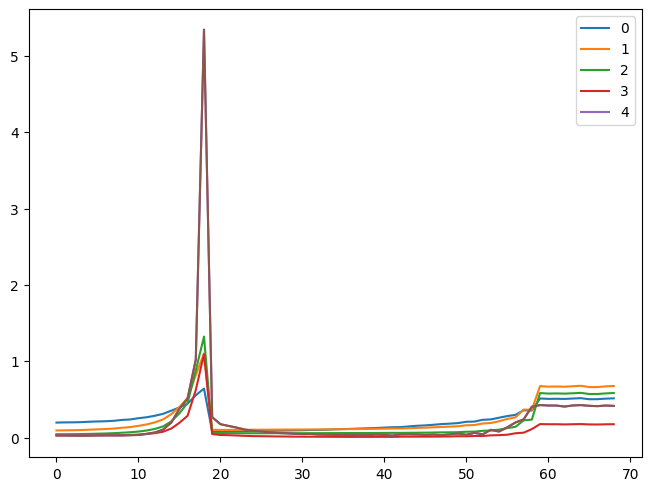

In [ ]:
for l in model.act_stds: plt.plot(l)
plt.legend(range(5));

### Pytorch Hooks 

Hooks are PyTorch object you can add to any nn.Module. A hook will be called when a layer, it is registered to, is executed during the forward pass (forward hook) or the backward pass (backward hook). Hooks don't require us to rewrite the model.

In [ ]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

In [ ]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): Flatten(start_dim=1, end_dim=-1)
)

A hook is attached to a layer, and needs to have a function that takes three arguments: module, input, output. Here we store the mean and std of the output in the correct position of our list.

In [ ]:
act_means = [[] for _ in model]
act_stds  = [[] for _ in model]

In [ ]:
def append_stats(i, mod, inp, outp):
    act_means[i].append(to_cpu(outp).mean())
    act_stds[i].append(to_cpu(outp).std())

[Link to pytorch forward hook docs](https://pytorch.org/docs/stable/generated/torch.nn.Module.html?highlight=register_forward_hook#torch.nn.Module.register_forward_hook)

In [ ]:
# Register the hooks
for i,m in enumerate(model): m.register_forward_hook(partial(append_stats, i))

accuracy,loss,epoch,train
0.152,2.299,0,train
0.200,2.045,0,eval


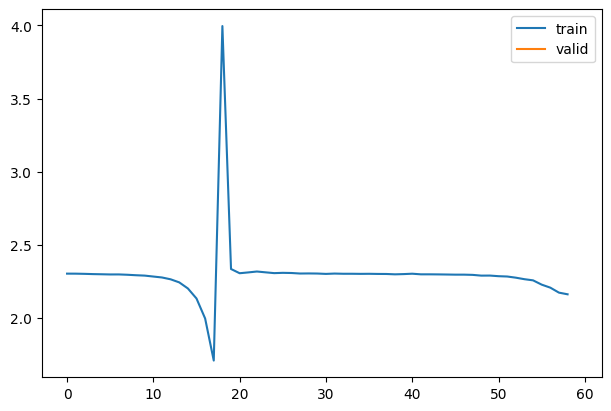

<miniai.learner.Learner>

In [ ]:
fit(model, epochs=1)

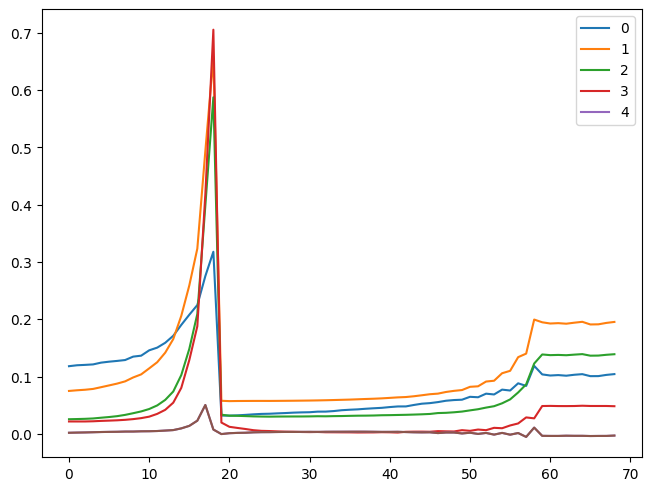

In [ ]:
for o in act_means: plt.plot(o)
plt.legend(range(5));

### Hook Class 

It is very important to both assign and then remove hooks otherwise it is likely to cause memory problems

In [ ]:
#| export
class Hook():
    """ Class to initilize and when necessary remove hooks in a Pytorch module.  The supplied
    function will be called after every forward call to the layer, when it will be called 
    with the layer input and outputs
    
    """
    def __init__(self, m: nn.Module, func: Callable): 
        """ Register the forward hook with the supplied module using the supplied function
        Note that the supplied function has to have signature of module, input, output
        
        args:
            m: The module layer to which the hook is to be assigned
            func: The function to be called immediately after any forward calls on the layer
        """
        self.hook = m.register_forward_hook(partial(func, self))
        
    def remove(self):
        self.hook.remove()
        
    def __del__(self):
        """ Ensure that the hook is removed when the class instance is deleted
        """
        self.remove()

In [ ]:
#| export
def append_stats(hook: Hook, mod: nn.Module, inp: torch.Tensor, outp: torch.Tensor):
    """ Record the activations of model layers using a hook.  For the supplied hook a new parameter
    'stats' is added, which will record the means and std deviation for each call of the hook.
    Since this is called every time the layer is used the position in each list reflects the step
    
    Args:
        hook: the hook for which the activations are being recorded
        mod: the module of the model to which the hook is assigned (unused)
        inp: the input to the layer (unused)
        outp:the output activations
    
    """
    # Initialize hook by adding stats attribute.
    if not hasattr(hook, 'stats'):
        hook.stats = ([], [])
    acts = to_cpu(outp)
    hook.stats[0].append(acts.mean())
    hook.stats[1].append(acts.std())

In [ ]:
set_seed(1)
model = nn.Sequential(*cnn_layers())
learn = Learner(model, dls=dls, loss_func=F.cross_entropy,  lr=0.6, cbs=cbs)

In [ ]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): Flatten(start_dim=1, end_dim=-1)
)

In [ ]:
hooks = [Hook(l, append_stats) for l in model[:5].children()]

accuracy,loss,epoch,train
0.155,2.301,0,train
0.199,2.130,0,eval


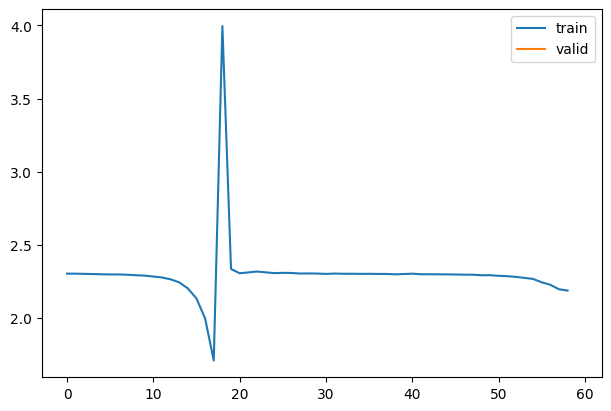

In [ ]:
learn = fit(model, epochs=1)

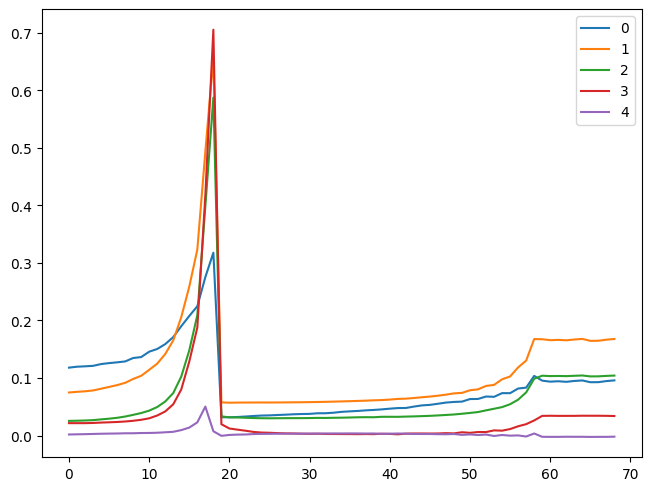

In [ ]:
# Plot the activations stats and remove the hooks
for h in hooks:
    # plot the means (stats[0])
    plt.plot(h.stats[0])
    h.remove()
plt.legend(range(5));

In [ ]:
[child for child in iter(model[:5].children())]

[Sequential(
   (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
   (1): ReLU()
 ),
 Sequential(
   (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (1): ReLU()
 ),
 Sequential(
   (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (1): ReLU()
 ),
 Sequential(
   (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (1): ReLU()
 ),
 Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))]

### A Hooks Class
It is possible to use a context manager to ensure that all hooks are removed when no longer needed

In [ ]:
class DummyCtxMgr:
    def __enter__(self, *args):
        print("let's go!")
        return self
    def __exit__ (self, *args): print("all done!")
    def hello(self): print("hello.")

In [ ]:
with DummyCtxMgr() as dcm:
    dcm.hello()

let's go!
hello.
all done!


In [ ]:
class DummyList(list):
    def __delitem__(self, i):
        print(f"Say bye to item {i}")
        super().__delitem__(i)

In [ ]:
dml = DummyList([1,3,2])
dml

[1, 3, 2]

In [ ]:
del(dml[2])

Say bye to item 2


In [ ]:
dml

[1, 3]

In [ ]:
#|export
class Hooks(list):
    """ Class to act as a container and context manager for a set of hooks and to ensure that they are 
    all removed at the end.  
    
    For the context manager the very least that is needed is an __enter__ and __exit__. 
    Inherits from the list class so that it is possible to iterate through members of the class as though
    it was a list.  This requires use of the list super class initilization
    
    Note that this works by iterating through layers as in an nn.Sequential model.  If the model has a
    different structure this class is likely to need modification
    
    The __del__ method is called to ensure that when the instance of the class is deleted then the associated
    hooks are also deleted
    
    """
    def __init__(self, mdl, func):
        # Initialize a hook for each layer and assign to a list
        super().__init__([Hook(l, func) for l in mdl])
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.remove()
    def __del__(self):
        # triggered to delete the class.  This calls the remove method to remove all of the hooks
        self.remove()
    def __delitem__(self, i):
        # delete a specific hook from the model
        self[i].remove()
        # remove the hook from the list
        super().__delitem__(i)
    def remove(self): 
        for h in self: h.remove()

In [ ]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

accuracy,loss,epoch,train
0.156,2.297,0,train
0.283,2.015,0,eval


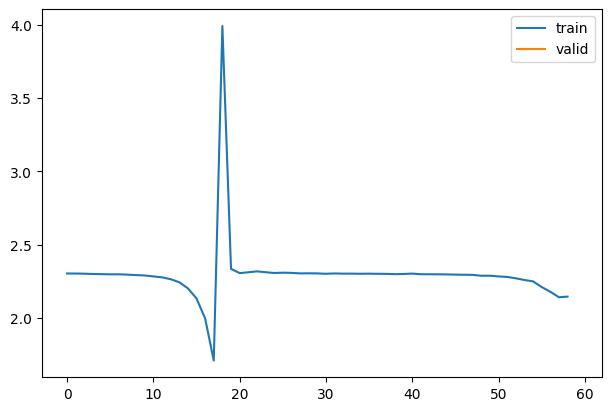

<matplotlib.legend.Legend>

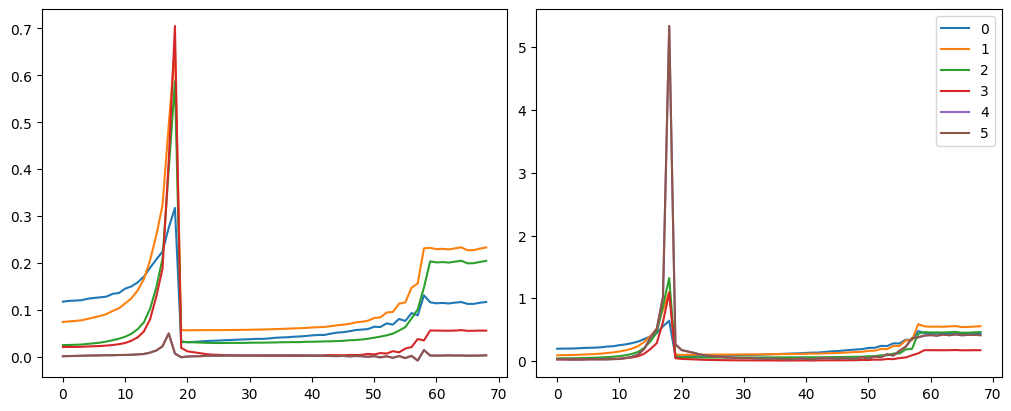

In [ ]:
with Hooks(model, append_stats) as hooks:
    fit(model, epochs=1)
    fig, axs = plt.subplots(1,2, figsize=(10, 4))
    for h in hooks:
        for i in 0, 1: axs[i].plot(h.stats[i])
plt.legend(range(6))

### Hooks Callback

Now that there is a class to manage the hooks a more flexible way of implementing it is needed. In particular it is necessary to be able to filter the list of layers to allow selection of specific types or cases, and to only apply the hook function during training

In [ ]:
#|export
class HooksCallback(Callback):
    def __init__(self, hookfunc, module_filter=fc.noop, on_train: bool=True, on_valid:bool=False, 
                mods=None):
        """ mods should be a set of layers to which hooks should be applied.  If mods
        is supplied then module_filter is not used.
        
        args:
            hookfunc: Function that will be called on the layers selected
            module_filter: A function to use to select the layers to use (defaults to fc.noop, which
              will select all.  Typically use a function such as fc.filter_ex to define specific
              types of layers.  When using this approach with large models many layers will end 
              up with hooks attached and so it can be better to use the mods option below to select
              a specific list of layers
            on_train: If true then the hool will be applied on training
            on_valid: if true that applies the hook during validation
            mods: If supplied then should be a list of layers to which the hooks will be applied.
              When supplied then the module_filter is not used. The list can be indexed layers of 
              the model or a list created using model.named_children where that works.
              Defaults to None
            
        """
        fc.store_attr()
        super().__init__()
    
    def before_fit(self, learn): 
        if self.mods:
            mods = self.mods
        else:
            # get list of filtered layers
            mods = fc.filter_ex(learn.model.modules(), self.module_filter)
        # create hooks
        self.hooks = Hooks(mods, partial(self._hookfunc, learn))
    
    def _hookfunc(self, learn, *args, **kwargs):
        if (self.on_train and learn.training) or \
            (self.on_valid and not learn.training): self.hookfunc(*args, **kwargs)
    
    def after_fit(self, learn): self.hooks.remove()
    
    def __iter__(self): return iter(self.hooks)
    def __len__(self): return len(self.hooks)

Check the functionality of the module selection and that it selects both within the sub modelules as well as at the top layer

In [ ]:
module_filter = fc.risinstance(nn.Conv2d)

In [ ]:
selected_layers = fc.filter_ex(model.modules(),module_filter)
selected_layers

[Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2)),
 Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
 Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
 Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
 Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))]

In [ ]:
assert len(selected_layers) == 5

Create a hook callback using the above filter and assign to a learner with the model.  By calling the before_fit method check that the correct number of hooks are created

In [ ]:
hc = HooksCallback(append_stats, fc.risinstance(nn.Conv2d))
xtra_cbs=[hc]
learn = Learner(model, dls=dls, loss_func=F.cross_entropy,  lr=0.6, cbs=cbs+fc.L(xtra_cbs))

In [ ]:
learn.cbs[4].before_fit(learn)

In [ ]:
assert len(hc) == 5

In [ ]:
for hook in hc.hooks:
    assert isinstance(hook, Hook)

Also check that the mods argument selects and generated the correct hooks

In [ ]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): Flatten(start_dim=1, end_dim=-1)
)

Select the second Relu and the last conv layer using the mod argument

In [ ]:
sel_layers = [
    model[1][1], model[4]
]
hc_mods = hc = HooksCallback(append_stats, mods=sel_layers)
xtra_cbs=[hc_mods]
learn = Learner(model, dls=dls, loss_func=F.cross_entropy,  lr=0.6, cbs=cbs+fc.L(xtra_cbs))
learn.cbs[-1].before_fit(learn)

In [ ]:
assert len(hc_mods.hooks) == 2

In [ ]:
for hook in hc_mods.hooks:
    assert isinstance(hook, Hook)

Train model with HookCallbacks

accuracy,loss,epoch,train
0.156,2.297,0,train
0.279,2.016,0,eval


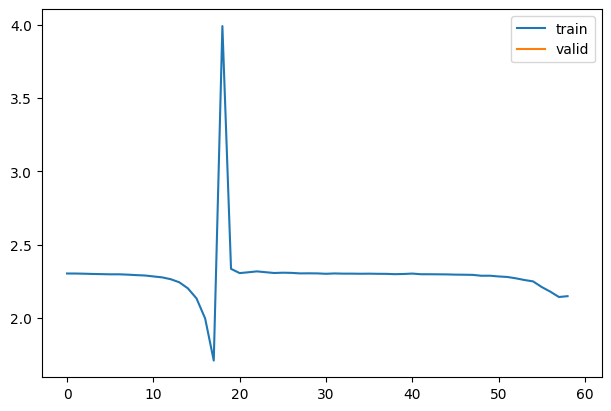

<miniai.learner.Learner>

In [ ]:
set_seed(1)
model = nn.Sequential(*cnn_layers())
hc = HooksCallback(append_stats, fc.risinstance(nn.Conv2d))
xtra_cbs=[hc]
fit(model, epochs=1, xtra_cbs=xtra_cbs)

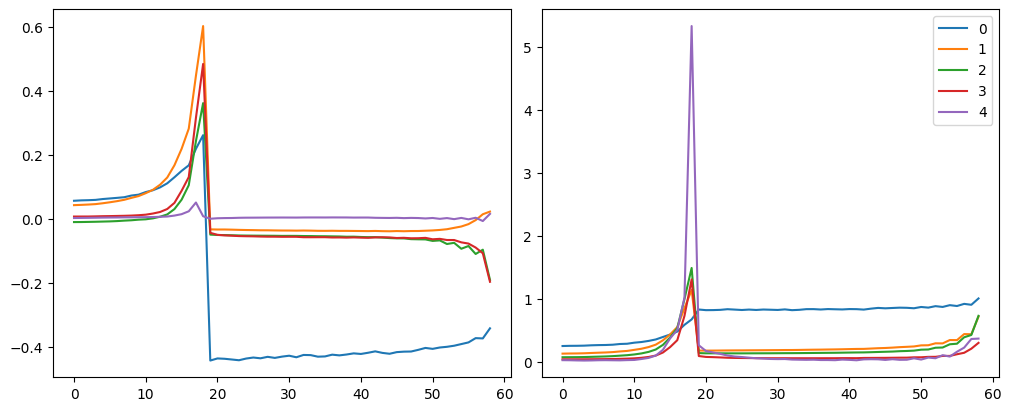

In [ ]:
fig,axs = plt.subplots(1,2, figsize=(10,4))
for h in hc:
    for i in 0,1: axs[i].plot(h.stats[i])
plt.legend(range(6));

### Enhanced ways to visulise the activations (Histograms)

By calculating and storing a histogram of the activations for each layer and batch we can get a better visulisation as to how the activations vary

In [ ]:
#| export
def append_stats(hook: Hook, mod: nn.Module, inp: torch.Tensor, outp: torch.Tensor):
    """ Record the activations of model layers using a hook.  For the supplied hook a new parameter
    'stats' is added, which will record the means and std deviation for each call of the hook.
    Since this is called every time the layer is used the position in each list reflects the step
    The hook property will contain three lists, one for the activation means at each call, one for
    the standard deviation and one containing a histogram of the activations
    
    Args:
        hook: the hook for which the activations are being recorded
        mod: the module of the model to which the hook is assigned (unused)
        inp: the input to the layer (unused)
        outp:the output activations
    
    """
    if not hasattr(hook,'stats'): hook.stats = ([],[],[])
    acts = to_cpu(outp)
    hook.stats[0].append(acts.mean())
    hook.stats[1].append(acts.std())
    hook.stats[2].append(acts.abs().histc(bins=40, min=0, max=10))

accuracy,loss,epoch,train
0.155,2.301,0,train
0.199,2.131,0,eval


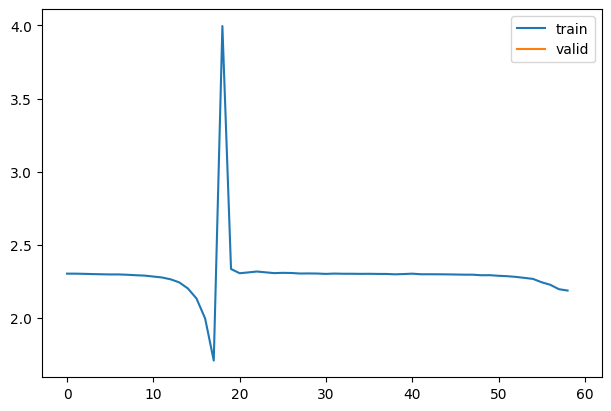

In [ ]:
set_seed(1)
model = nn.Sequential(*cnn_layers())
hc = HooksCallback(append_stats, module_filter=fc.risinstance(nn.Conv2d))
fit(model, epochs=1, xtra_cbs=[hc]);

In [ ]:
#| export
# Thanks to @ste for initial version of histgram plotting code
def get_hist(h: Hook):
    """ Take the data gathered by a the HooksCallback and prepare in a form suitable
    for plotting.  Note that the log of the activation values is plotted
    args:
        h: the hook to be processed
        
    returns:
        A new array of stacked histograms that can be plotted as a density image
    """
    return torch.stack(h.stats[2]).t().float().log1p()

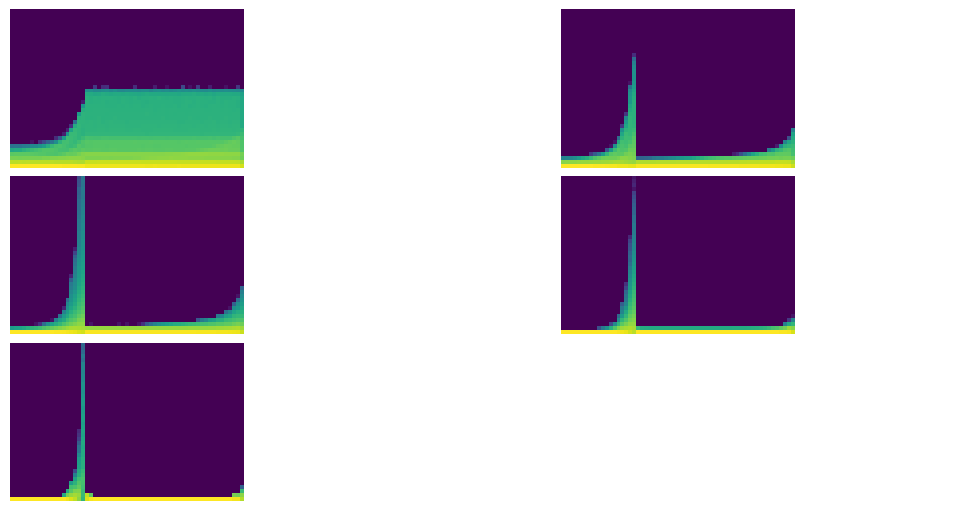

In [ ]:
fig,axes = get_grid(len(hc), figsize=(11,5))
for ax,h in zip(axes.flat, hc):
    show_image(get_hist(h), ax, origin='lower')

In [ ]:
h1 = torch.stack(hc.hooks[0].stats[2]).t().float()

In [ ]:
h1.shape, h1[0].shape

(torch.Size([40, 59]), torch.Size([59]))

`h1[0].shape` is the sum of values in the minimum bin for each batch
`h1.sum(0)` is the total number of activations for each batch
Thus the value returned is the proportion of the total activations in the minimum bin

In [ ]:
h1.sum(0).shape

torch.Size([59])

In [ ]:
h1[0]/h1.sum(0)

tensor([0.76, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.74, 0.74, 0.73, 0.73, 0.72, 0.71, 0.69, 0.69, 0.69, 0.67, 0.65, 0.53, 0.53, 0.53,
        0.53, 0.52, 0.53, 0.53, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.51, 0.51, 0.52, 0.51, 0.51, 0.51, 0.51, 0.51, 0.52, 0.51,
        0.50, 0.51, 0.51, 0.50, 0.51, 0.51, 0.50, 0.51, 0.50, 0.51, 0.50, 0.51, 0.51, 0.51, 0.50])

In [ ]:
#|export
def get_min(h):
    """ Calculate the proportion of activations in the smallest bin
    """
    h_arr = torch.stack(h.stats[2]).t().float()
    return h_arr[0] / h_arr.sum(0)

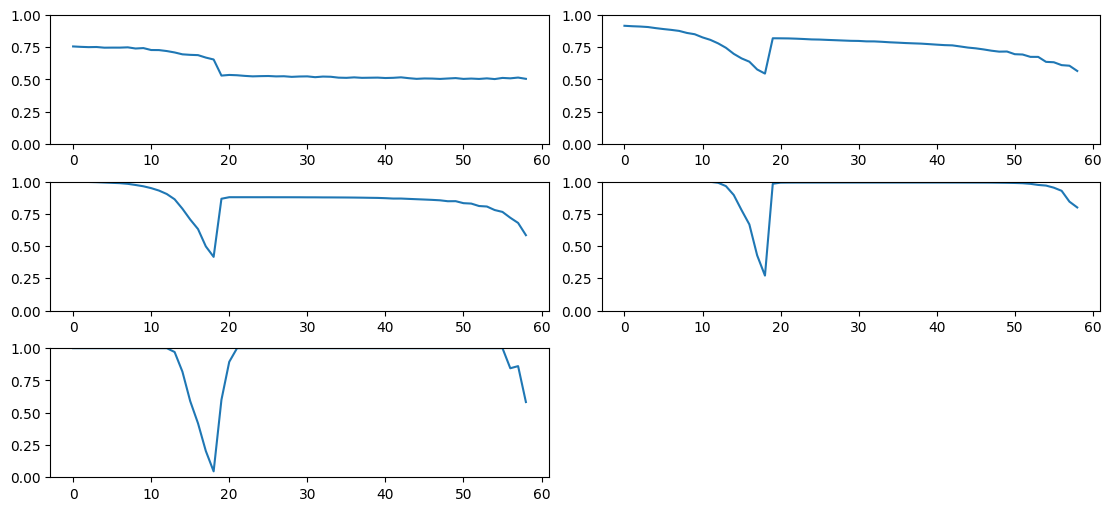

In [ ]:
fig,axes = get_grid(len(hc), figsize=(11,5))
for ax,h in zip(axes.flatten(), hc):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)

The above plots clearly show that many of the activations are doing nothing for much of the training and are effectively zero

### Activation Stats 

The above plotting routines can be put into a class to make them available for easy plotting after training

In [ ]:
#|export
class ActivationStatsCB(HooksCallback):
    """ Adds visulisation capability to the HookCallback.
    Three types of chart can be produced by the class methods.

    color_dim: 
    """
    def __init__(self, module_filter=fc.noop):
        super().__init__(append_stats, module_filter)
        
    def color_dim(self, figsize=(11,5)):
        fig,axes = get_grid(len(self), figsize=figsize)
        for ax,h in zip(axes.flat, self):
            show_image(get_hist(h), ax, origin='lower')
    
    def dead_chart(self, figsize=(11,5)):
        fig,axes = get_grid(len(self), figsize=(11,5))
        for ax,h in zip(axes.flatten(), self):
            ax.plot(get_min(h))
            ax.set_ylim(0,1)

    def plot_stats(self, figsize=(10,4)):
        fig,axs = plt.subplots(1,2, figsize=figsize)
        for h in self:
            for i in 0,1: 
                axs[i].plot(h.stats[i])
        axs[0].set_title('Means')
        axs[1].set_title('Stdevs')
        plt.legend(fc.L.range(self))

In [ ]:
astats = ActivationStatsCB(fc.risinstance(nn.Conv2d))

accuracy,loss,epoch,train
0.154,2.301,0,train
0.197,2.122,0,eval


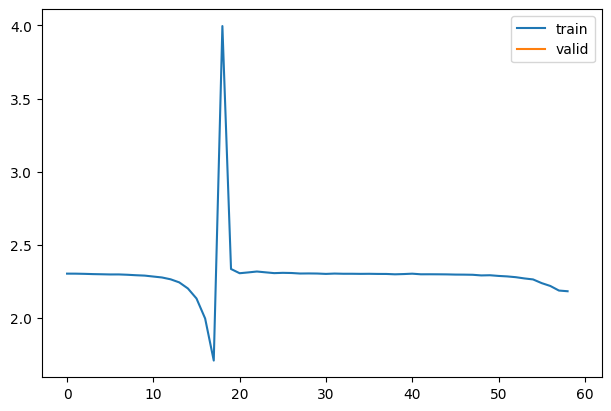

In [ ]:
set_seed(1)
model = nn.Sequential(*cnn_layers())
fit(model, epochs=1, xtra_cbs=[astats]);

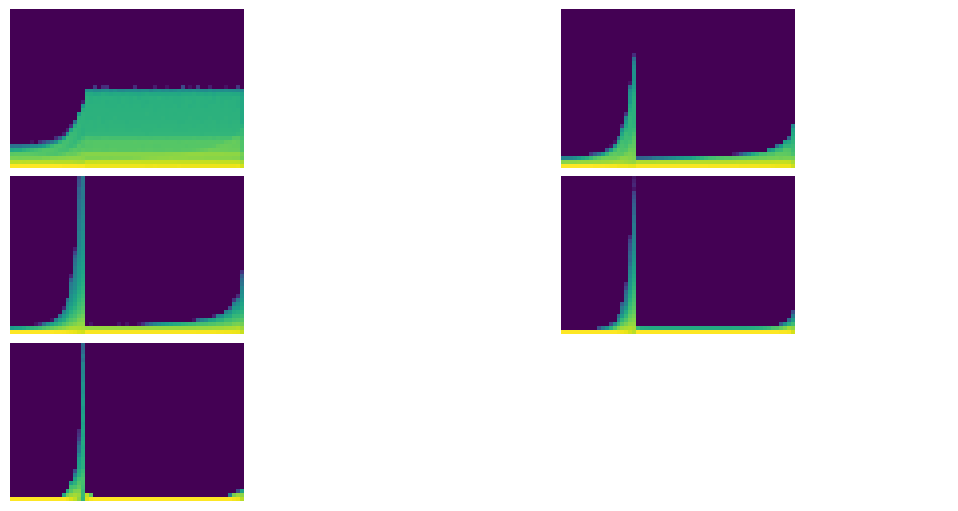

In [ ]:
astats.color_dim()

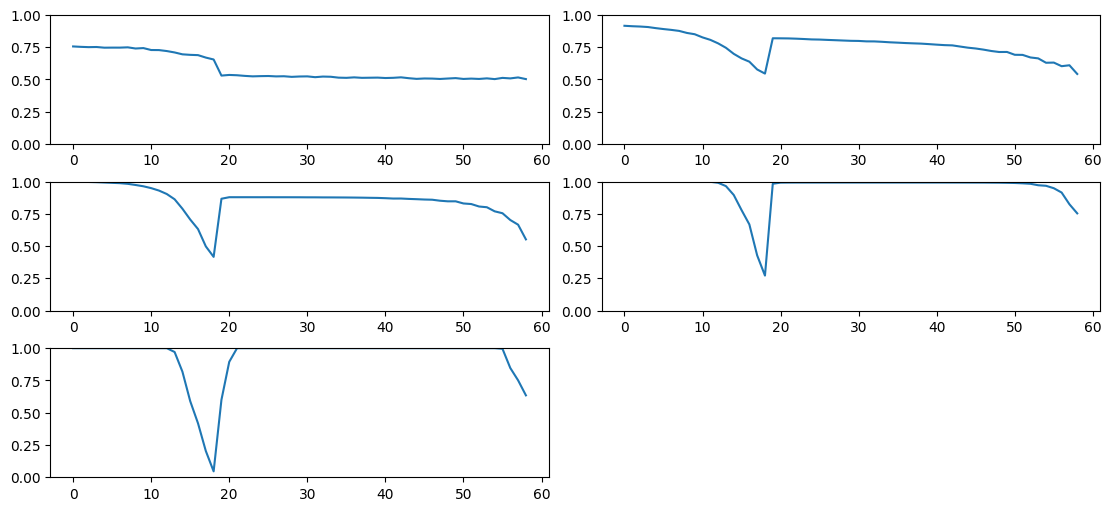

In [ ]:
astats.dead_chart()

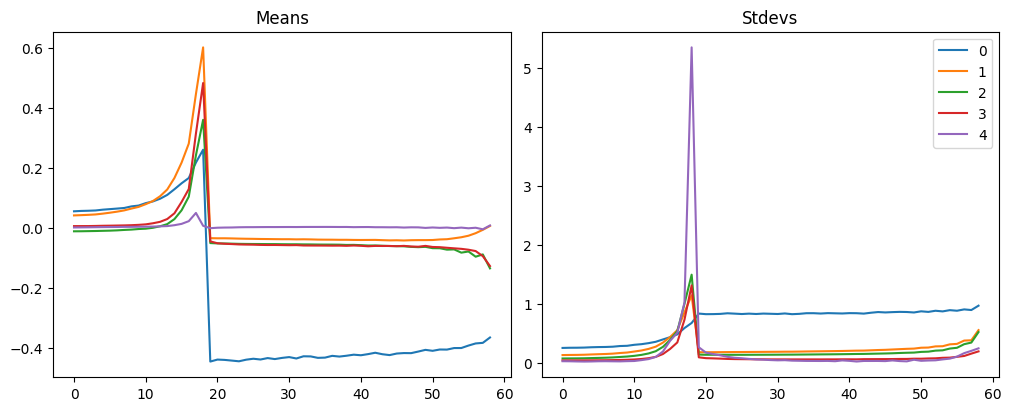

In [ ]:
astats.plot_stats()

### Export 

In [ ]:
import nbdev; nbdev.nbdev_export()